# Zonal Statistics with XArray

## Introduction

The Zonal Statistics extracts the values of a raster within the zones of another dataset and computes statistical summary. XArray ecosystem includes `rioxarray` and `xrspatial` packages that can perform very fast statistical operation on geospatial rasters. We use these along with the `geocube` package to convert a vector layer to a rastrized XArray dataset. This approach ensures you leverages the efficiences of XArray and results in performance that is magnitudes faster than other approaches (i.e. with `rasterstats`).

## Overview of the Task

We will use a gridded precipitation raster and extract the mean total precipitaion for each county in the state of California, USA.

**Input Layers**:

* `chirps-v2.0.2021.tif`: Raster grid of precipitaion for 2021  by Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) for 2021.
*  `cb_2021_us_county_500k.zip`: A vector file with polygons representing counties  in the US.

**Output Layers**:
*   `precipitation.gpkg` : A GeoPackage containing a vector layer of county polygon with total precipitaion values sampled from the raster.


**Data Credit**:
*   [CHIRPS 2021 precipitation](https://data.chc.ucsb.edu/products/CHIRPS-2.0/). Climate Hazards Center (CHC). Retrieved 2022-09

*   [US Census files: 2021](https://www2.census.gov/geo/tiger/GENZ2021/) United States Census Bureau. Retrieved 2022-09.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray geocube xarray_spatial

In [19]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
from xrspatial import zonal_stats

In [6]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [8]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 'chirps-v2.0.2021.tif'
zones_file = 'cb_2021_us_county_500k.zip'

files = [
    'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_annual/tifs/' + raster_file,
    'https://www2.census.gov/geo/tiger/GENZ2021/shp/' + zones_file,
]

for file in files:
  download(file)

# Data Pre-Processing

First we will read the  Zipped counties shapefile and filter out the counties that are in `California` state.

The dataframe has a column  as `STATE_NAME` having naesm of states that can be used to filter the counties for *California*.

In [22]:
zones_file_path = os.path.join(data_folder, zones_file)

zones_df = gpd.read_file(zones_file_path)
california_df  = zones_df[zones_df['STATE_NAME'] == 'California'].copy()
california_df.iloc[:5, :5]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID
47,06,059,00277294,0500000US06059,06059
50,06,111,00277320,0500000US06111,06111
94,06,063,00277296,0500000US06063,06063
181,06,015,01682074,0500000US06015,06015
245,06,023,01681908,0500000US06023,06023


The 'GEOID' column contains a unique id for all the counties present in the state, but it is of `object` type. We need to convert it to `int` type to be used in xarray.

Since the CHIRPS dataset is for whole world, so we clip it to the bounds of *California* state. Storing the values of bounding box in the required variables.   

 Now, read the raster file using `rioxarray` and clip it to the geometry of *California* state.

In [10]:
raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True).rio.clip(california_df.geometry)
raster

<xarray.DataArray (band: 1, y: 189, x: 205)> Size: 155kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -124.4 -124.3 -124.3 ... -114.3 -114.2 -114.2
  * y            (y) float64 2kB 41.97 41.92 41.87 41.82 ... 32.67 32.62 32.57
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/annual/v2.0/chirps-v2.0.2021.tif
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.7.2, Harris Geospatial Solutions, Inc.
    TIFFTAG_DATETIME:          2022:01:18 14:24:32
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    AREA_OR_POINT:             Area

You will notice that the raster has many pixels with value -9999. These are NoData values but they are not encoded as such. We will mask these values to get only the valid pixels.

The raster has only 1 band containing yearly precipitaion values, so we select it.

In [11]:
precipitation = raster.sel(band=1)
precipitation

<xarray.DataArray (y: 189, x: 205)> Size: 155kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -124.4 -124.3 -124.3 ... -114.3 -114.2 -114.2
  * y            (y) float64 2kB 41.97 41.92 41.87 41.82 ... 32.67 32.62 32.57
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/annual/v2.0/chirps-v2.0.2021.tif
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.7.2, Harris Geospatial Solutions, Inc.
    TIFFTAG_DATETIME:          2022:01:18 14:24:32
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    AREA_OR_POINT:             Area

## Sampling Raster Values

Now we will extract the value of the raster pixels for every counties in California. We will be using the `geocube` module for that. It takes geodataframe, it's unique value as integer and a xarray dataset as input and converts the geodataframe into  a `xarray dataset` having dimension and coordinates same as of given input xarray dataset


In [12]:
california_df['GEOID'] = california_df.GEOID.astype(int)
california_raster = make_geocube(
    vector_data=california_df,
    measurements=['GEOID'],
    like=precipitation,
)
california_raster

<xarray.Dataset> Size: 313kB
Dimensions:      (y: 189, x: 205)
Coordinates:
  * y            (y) float64 2kB 41.97 41.92 41.87 41.82 ... 32.67 32.62 32.57
  * x            (x) float64 2kB -124.4 -124.3 -124.3 ... -114.3 -114.2 -114.2
    spatial_ref  int64 8B 0
Data variables:
    GEOID        (y, x) float64 310kB nan nan nan nan ... nan nan nan nan

Now we can use the [Zonal Stats](https://xarray-spatial.readthedocs.io/en/stable/user_guide/zonal.html#Zonal-Statistics) function from xarray-spatial to compute various statistics for each zone.

In [20]:
stats_df = zonal_stats(zones=california_raster.GEOID, values=precipitation)
stats_df.iloc[:5]

,zone,mean,max,min,sum,std,var,count
0,6001.0,371.543365,607.836914,177.121490,29351.925781,90.103966,8118.724121,79.0
1,6003.0,709.821960,1099.949951,481.242493,56075.933594,130.407578,17006.134766,79.0
2,6005.0,748.022400,1076.544678,416.273926,50117.500000,202.018219,40811.359375,67.0
3,6007.0,720.174438,1303.399902,428.850677,135392.796875,233.186996,54376.171875,188.0
4,6009.0,680.377014,1204.727417,314.935669,74161.093750,233.036972,54306.230469,109.0


We select the required statistics and join the results with the original layer.

In [18]:
stats_df['GEOID'] = stats_df['zone'].astype(int)
joined = california_df.merge(stats_df[['GEOID', 'mean']], on='GEOID')
joined.iloc[:5, -5:]

,LSAD,ALAND,AWATER,geometry,mean
0,06,2053476505,406279630,"POLYGON ((-118.11442 33.74518, -118.11305 33.7...",262.130493
1,06,4767622161,947345735,"MULTIPOLYGON (((-119.44123 34.01408, -119.4366...",339.915070
2,06,6612400772,156387638,"POLYGON ((-121.49703 40.43702, -121.49487 40.4...",834.308716
3,06,2606118035,578742633,"MULTIPOLYGON (((-124.2175 41.95081, -124.21704...",2439.237549
4,06,9241565229,1253726036,"POLYGON ((-124.4086 40.4432, -124.39664 40.462...",1273.892456


Let's plot and visualize the results. The map shows the average annual precipitation for each county in California.

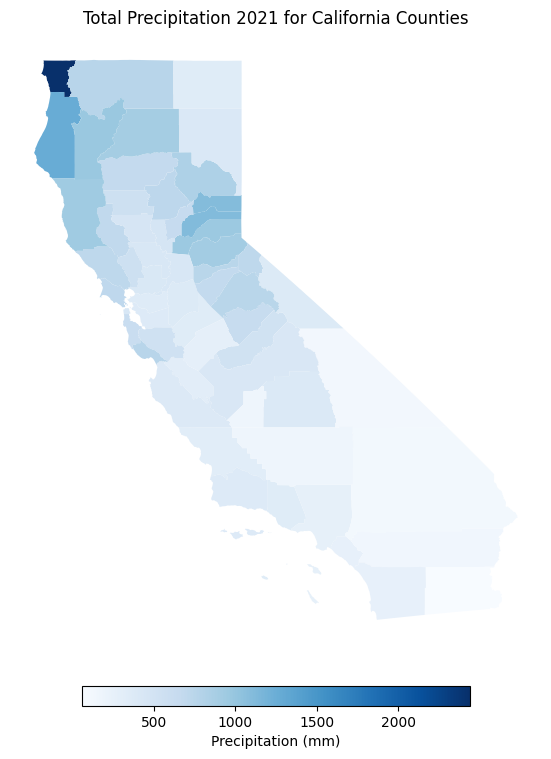

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

legend_kwds={
           'orientation': 'horizontal',  # Make the legend horizontal
           'shrink': 0.5,  # Reduce the size of the legend bar by 50%
           'pad': 0.05,  # Add some padding around the legend
           'label': 'Precipitation (mm)',  # Set the legend label (optional)
       }
joined.plot(ax=ax, column='mean', cmap='Blues',
          legend=True, legend_kwds=legend_kwds)
ax.set_axis_off()
ax.set_title('Total Precipitation 2021 for California Counties')
plt.show()

Finally, we save the sampled result to disk as `.gpkg`.

In [28]:
output_file = 'precipitation_by_county.gpkg'
output_path = os.path.join(output_folder, output_file)

joined.to_file(driver = 'GPKG', filename =output_path)
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/precipitation_by_county.gpkg
